In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG
# import CairoSVG
import numpy as np

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "causal-cmd-1.2.0-SNAPSHOT-jar-with-dependencies.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/causal-cmd-1.2.0-SNAPSHOT-jar-with-dependencies.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '200000M')
javabridge.attach()

In [4]:
df = pd.read_csv("../../data/income.csv")
print(df.shape)
df.head()

(43957, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [5]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income_>50K'],
      dtype='object')

# encode and normalize data

In [6]:
df = df[[ 
#     'fnlwgt',
    'age', 'workclass', 
    'education', 
#     'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income_>50K'
]]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 13 columns):
age               43957 non-null int64
workclass         41459 non-null object
education         43957 non-null object
marital-status    43957 non-null object
occupation        41451 non-null object
relationship      43957 non-null object
race              43957 non-null object
gender            43957 non-null object
capital-gain      43957 non-null int64
capital-loss      43957 non-null int64
hours-per-week    43957 non-null int64
native-country    43194 non-null object
income_>50K       43957 non-null int64
dtypes: int64(5), object(8)
memory usage: 4.4+ MB


In [8]:
cont_var_list = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 
#                  'fnlwgt'
                ]
disc_var_list = ['workclass', 
                 'education', 
#                  'educational-num',
       'marital-status', 'occupation', 
                 'relationship', 'race', 'gender','native-country',
       'income_>50K']

In [9]:
df.isnull().sum()

age                  0
workclass         2498
education            0
marital-status       0
occupation        2506
relationship         0
race                 0
gender               0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     763
income_>50K          0
dtype: int64

In [10]:
df = df.dropna()
df = df.reset_index(drop=True)
df.shape

df = df.sample(n=15000)

# Reset index
df = df.reset_index(drop=True)

In [11]:
# level_mapping={'Preschool':0,'1st-4th':1,'5th-6th':2, '7th-8th':3, '9th':4, '10th':5, '11th':6, '12th':7,
#               'HS-grad':8, 'Some-college':9, 'Bachelors':10, 'Prof-school':11, 'Assoc-voc':12, 
#                'Assoc-acdm':13, 'Masters':14, 'Doctorate':15
#               }

# df['education'] = df['education'].replace(level_mapping)

In [12]:
df.shape

(15000, 13)

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for var in disc_var_list:
    df[var] = label_encoder.fit_transform(df[var])

In [14]:
from scipy.stats import boxcox
import numpy as np

for col in cont_var_list:
    min_value = df[col].min()
    # Add a constant to ensure positivity
    data = df[col] - min_value + 1
    df[col], _ = boxcox(data)

In [15]:
# edu = ['Preschool','1st-4th','5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
#               'HS-grad', 'Some-college', 'Bachelors', 'Prof-school', 'Assoc-voc', 
#                'Assoc-acdm', 'Masters', 'Doctorate']

In [16]:
numCategoriesToDiscretize = 4
node_list = javabridge.JClassWrapper('java.util.ArrayList')()
cont_list = []
disc_list = []
col_no = 0
for col in df.columns:   
    if col in cont_var_list:
        # Continuous variable
        nodi = javabridge.JClassWrapper('edu.cmu.tetrad.data.ContinuousVariable')(col)
        node_list.add(nodi)

        cont_list.append(col_no)

    else:
        # Discrete variable
        cat_array = sorted(set(df[col]))
#         if col=='education':
#             cat_array = edu
        cat_list = javabridge.JClassWrapper('java.util.ArrayList')()
        for cat in cat_array:
#             print(cat)
            cat = str(cat)
            cat_list.add(cat)

        nodname = javabridge.JClassWrapper('java.lang.String')(col)
#         print(nodname)
#         print(cat_list)
        nodi = javabridge.JClassWrapper('edu.cmu.tetrad.data.DiscreteVariable')(nodname,cat_list)
        node_list.add(nodi)

        disc_list.append(col_no)

    col_no = col_no + 1

In [17]:
node_list

Instance of java.util.ArrayList: [age, workclass, education, marital-status, occupation, relationship, race, gender, capital-gain, capital-loss, hours-per-week, native-country, income_>50K]

In [18]:
len(df.index)

15000

In [19]:
mixedDataBox = javabridge.JClassWrapper('edu.cmu.tetrad.data.MixedDataBox')(node_list, len(df.index))

In [20]:
for row in df.index:

    for col in cont_list:
        value = javabridge.JClassWrapper('java.lang.Double')(df.iloc[row,col])
#         print("value cont list", value)
        mixedDataBox.set(row,col,value)

    for col in disc_list:
        cat_array = sorted(set(df[df.columns[col]]))
        value = javabridge.JClassWrapper('java.lang.Integer')(cat_array.index(df.iloc[row,col]))
#         print("value disc list", value)
        mixedDataBox.set(row,col,value)

In [21]:
tetradData = javabridge.JClassWrapper('edu.cmu.tetrad.data.BoxDataSet')(mixedDataBox, node_list)

### independence tests

In [22]:
alpha = 0.05
discretize = False
indTest = javabridge.JClassWrapper('edu.cmu.tetrad.search.IndTestConditionalGaussianLRT')(tetradData, alpha, discretize)

### pc algorithm

In [23]:
pc = javabridge.JClassWrapper('edu.cmu.tetrad.search.Pc')(indTest)

In [24]:
# rfci.setDepth(-1)
# rfci.setVerbose(True)

In [25]:
# prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
# prior.setForbidden('TangibilityCondition', 'Impact') # forbidden directed edges
# prior.setRequired('Sympathy','TangibilityCondition') # required directed edges
# prior.setTierForbiddenWithin(0, True)
# prior.addToTier(0, 'TangibilityCondition')
# prior.addToTier(0, 'Imaginability')
# prior.addToTier(1, 'Sympathy')
# prior.addToTier(1, 'AmountDonated')
# prior.addToTier(2, 'Impact')
# rfci.setKnowledge(prior)
# prior

In [26]:
tetradGraph = pc.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraph: Graph Nodes:
age;workclass;education;marital-status;occupation;relationship;race;gender;capital-gain;capital-loss;hours-per-week;native-country;income_>50K

Graph Edges:
1. age --> capital-gain
2. age --> income_>50K
3. age --> marital-status
4. age --> relationship
5. capital-loss --> capital-gain
6. capital-loss --> income_>50K
7. education --> hours-per-week
8. education --> occupation
9. gender --> occupation
10. gender --> relationship
11. income_>50K --> capital-gain
12. marital-status --> capital-gain
13. race --- native-country
14. relationship --> hours-per-week
15. relationship --> marital-status
16. workclass --> hours-per-week
17. workclass --> occupation


In [27]:
tetradGraph.toString()

'Graph Nodes:\nage;workclass;education;marital-status;occupation;relationship;race;gender;capital-gain;capital-loss;hours-per-week;native-country;income_>50K\n\nGraph Edges:\n1. age --> capital-gain\n2. age --> income_>50K\n3. age --> marital-status\n4. age --> relationship\n5. capital-loss --> capital-gain\n6. capital-loss --> income_>50K\n7. education --> hours-per-week\n8. education --> occupation\n9. gender --> occupation\n10. gender --> relationship\n11. income_>50K --> capital-gain\n12. marital-status --> capital-gain\n13. race --- native-country\n14. relationship --> hours-per-week\n15. relationship --> marital-status\n16. workclass --> hours-per-week\n17. workclass --> occupation\n\n'

In [28]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [age, workclass, education, marital-status, occupation, relationship, race, gender, capital-gain, capital-loss, hours-per-week, native-country, income_>50K]

In [29]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [workclass --> hours-per-week, relationship --> marital-status, age --> relationship, gender --> occupation, age --> capital-gain, income_>50K --> capital-gain, workclass --> occupation, capital-loss --> income_>50K, marital-status --> capital-gain, age --> income_>50K, age --> marital-status, race --- native-country, relationship --> hours-per-week, gender --> relationship, education --> occupation, capital-loss --> capital-gain, education --> hours-per-week]

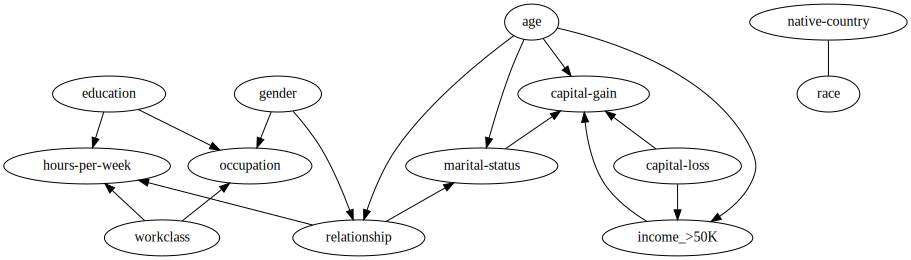

In [30]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [31]:
from IPython.display import HTML

# Your code to generate the SVG and store it in svg_str

# Define the desired width and height for the SVG
width = 400  # Change to your desired width
height = 300  # Change to your desired height

# Create an HTML string with CSS to set the width and height
html_str = '<div style="width:{}px; height:{}px">{}</div>'.format(width, height, svg_str)

# Display the HTML string in the notebook
HTML(html_str)


In [32]:
# javabridge.detach()
# javabridge.kill_vm() 

# Score based algo

In [33]:
structurePrior = 1.0
score = javabridge.JClassWrapper('edu.cmu.tetrad.search.ConditionalGaussianScore')(tetradData, structurePrior, True)
score.setPenaltyDiscount(2)# set to 2 if variable# <= 50 otherwise set it to 4

In [34]:
fges = javabridge.JClassWrapper("edu.cmu.tetrad.search.Fges")(score)

In [35]:
fges.setMaxDegree(-1)
# fges.setNumPatternsToStore(0)
fges.setFaithfulnessAssumed(True)
# fges.setParallelism(2)
fges.setVerbose(True)

In [36]:
tetradGraph = fges.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
age;workclass;education;marital-status;occupation;relationship;race;gender;capital-gain;capital-loss;hours-per-week;native-country;income_>50K

Graph Edges:
1. age --> capital-gain
2. age --> income_>50K
3. age --> marital-status
4. capital-loss --> capital-gain
5. capital-loss --> hours-per-week
6. gender --> age
7. gender --> hours-per-week
8. gender --- occupation
9. hours-per-week --> age
10. income_>50K --> capital-gain
11. native-country --- race
12. occupation --- education
13. occupation --> hours-per-week
14. occupation --- workclass
15. race --- relationship
16. relationship --> age
17. relationship --- gender
18. relationship --> hours-per-week
19. relationship --> income_>50K
20. relationship --> marital-status

Graph Attributes:
BIC: -398013.903494

Graph Node Attributes:
BIC: [age: -73266.974468;workclass: -26586.553520;education: -55597.567537;marital-status: -14805.211596;occupation: -67628.92

In [37]:
tetradGraph.toString()

'Graph Nodes:\nage;workclass;education;marital-status;occupation;relationship;race;gender;capital-gain;capital-loss;hours-per-week;native-country;income_>50K\n\nGraph Edges:\n1. age --> capital-gain\n2. age --> income_>50K\n3. age --> marital-status\n4. capital-loss --> capital-gain\n5. capital-loss --> hours-per-week\n6. gender --> age\n7. gender --> hours-per-week\n8. gender --- occupation\n9. hours-per-week --> age\n10. income_>50K --> capital-gain\n11. native-country --- race\n12. occupation --- education\n13. occupation --> hours-per-week\n14. occupation --- workclass\n15. race --- relationship\n16. relationship --> age\n17. relationship --- gender\n18. relationship --> hours-per-week\n19. relationship --> income_>50K\n20. relationship --> marital-status\n\nGraph Attributes:\nBIC: -398013.903494\n\nGraph Node Attributes:\nBIC: [age: -73266.974468;workclass: -26586.553520;education: -55597.567537;marital-status: -14805.211596;occupation: -67628.926713;relationship: -44386.431114;ra

In [38]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [age, workclass, education, marital-status, occupation, relationship, race, gender, capital-gain, capital-loss, hours-per-week, native-country, income_>50K]

In [39]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [relationship --> marital-status, gender --> age, occupation --> hours-per-week, relationship --> age, gender --- occupation, race --- relationship, age --> capital-gain, hours-per-week --> age, income_>50K --> capital-gain, occupation --- workclass, relationship --> income_>50K, age --> income_>50K, gender --> hours-per-week, age --> marital-status, native-country --- race, relationship --> hours-per-week, relationship --- gender, occupation --- education, capital-loss --> hours-per-week, capital-loss --> capital-gain]

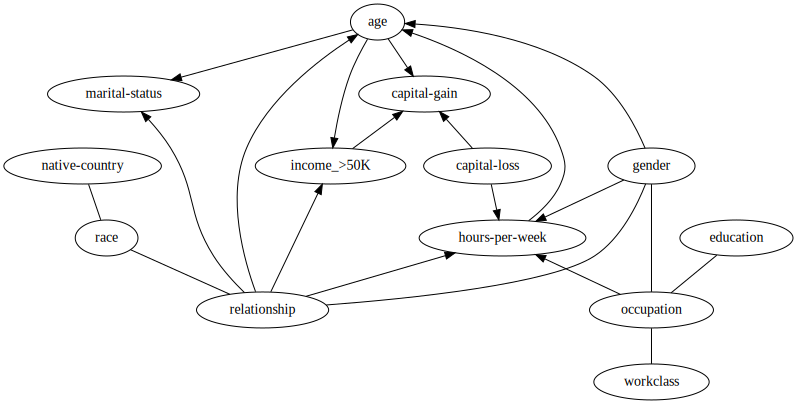

In [40]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [41]:
from IPython.display import HTML

# Your code to generate the SVG and store it in svg_str

# Define the desired width and height for the SVG
width = 400  # Change to your desired width
height = 300  # Change to your desired height

# Create an HTML string with CSS to set the width and height
html_str = '<div style="width:{}px; height:{}px">{}</div>'.format(width, height, svg_str)

# Display the HTML string in the notebook
HTML(html_str)

# Hybrid GFCI

In [42]:
alpha = 0.05
discretize = False
indTest = javabridge.JClassWrapper('edu.cmu.tetrad.search.IndTestConditionalGaussianLRT')(tetradData, alpha, discretize)

In [43]:
penaltydiscount = 2 # set to 2 if variable# <= 50 otherwise set it to 4
structurePrior = 1.0
score = javabridge.JClassWrapper('edu.cmu.tetrad.search.ConditionalGaussianScore')(tetradData, structurePrior, discretize)
score.setPenaltyDiscount(penaltydiscount) 

In [44]:
gfci = javabridge.JClassWrapper('edu.cmu.tetrad.search.GFci')(indTest, score)

In [45]:
gfci.setMaxDegree(3)
gfci.setMaxPathLength(-1)
gfci.setCompleteRuleSetUsed(False)
gfci.setFaithfulnessAssumed(True)
gfci.setVerbose(True)

In [46]:
tetradGraph = gfci.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
age;workclass;education;marital-status;occupation;relationship;race;gender;capital-gain;capital-loss;hours-per-week;native-country;income_>50K

Graph Edges:
1. hours-per-week --> age dd nl
2. race --> native-country dd nl
3. capital-gain o-o income_>50K
4. capital-gain o-> race
5. education o-o occupation
6. gender o-> race
7. gender o-o relationship
8. income_>50K o-> capital-loss
9. income_>50K o-o relationship
10. marital-status o-> age
11. marital-status o-> hours-per-week
12. occupation o-o gender
13. relationship o-o marital-status
14. workclass o-> capital-loss
15. workclass o-> hours-per-week
16. workclass o-o occupation

Graph Attributes:
BIC: -401581.857124


In [47]:
tetradGraph.toString()

'Graph Nodes:\nage;workclass;education;marital-status;occupation;relationship;race;gender;capital-gain;capital-loss;hours-per-week;native-country;income_>50K\n\nGraph Edges:\n1. hours-per-week --> age dd nl\n2. race --> native-country dd nl\n3. capital-gain o-o income_>50K\n4. capital-gain o-> race\n5. education o-o occupation\n6. gender o-> race\n7. gender o-o relationship\n8. income_>50K o-> capital-loss\n9. income_>50K o-o relationship\n10. marital-status o-> age\n11. marital-status o-> hours-per-week\n12. occupation o-o gender\n13. relationship o-o marital-status\n14. workclass o-> capital-loss\n15. workclass o-> hours-per-week\n16. workclass o-o occupation\n\nGraph Attributes:\nBIC: -401581.857124\n\n'

In [48]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [age, workclass, education, marital-status, occupation, relationship, race, gender, capital-gain, capital-loss, hours-per-week, native-country, income_>50K]

In [49]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [relationship o-o marital-status, workclass o-> hours-per-week, occupation o-o gender, hours-per-week --> age dd nl, capital-gain o-o income_>50K, workclass o-> capital-loss, workclass o-o occupation, income_>50K o-o relationship, income_>50K o-> capital-loss, marital-status o-> hours-per-week, marital-status o-> age, race --> native-country dd nl, gender o-o relationship, capital-gain o-> race, education o-o occupation, gender o-> race]

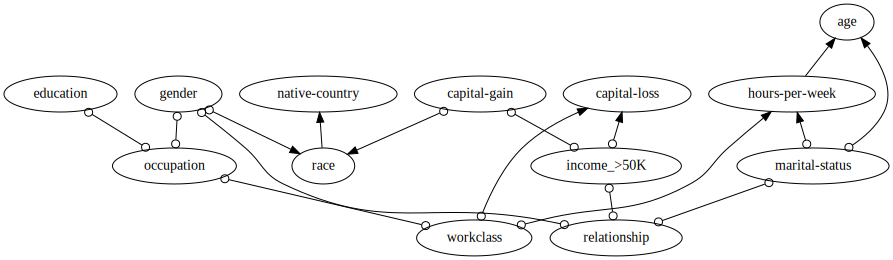

In [50]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [51]:
from IPython.display import HTML

# Your code to generate the SVG and store it in svg_str

# Define the desired width and height for the SVG
width = 400  # Change to your desired width
height = 300  # Change to your desired height

# Create an HTML string with CSS to set the width and height
html_str = '<div style="width:{}px; height:{}px">{}</div>'.format(width, height, svg_str)

# Display the HTML string in the notebook
HTML(html_str)

In [52]:
javabridge.detach()
javabridge.kill_vm()